# 🍃Part3: Predict the Churn User for Fitbod

In [1]:
# ----🍃Step0: Load Dataset🍃-----
import pandas as pd
import numpy as np
rawData =pd.read_csv('ob_peform.csv')

In [2]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
#ML libraries
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
#!pip yellowbrick
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.model_selection import GridSearchCV

# Step0: Additional EDA of Fitbod User Churn  in Data

In [3]:
#labels
lab = rawData["churn_user"].value_counts().keys().tolist()
#values
val = rawData["churn_user"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Fitbod User Churn Portion",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

⚠️ Unbalanced dataset!

(1) Can use F1 score (combination of precision and recall) and AUC to meausre the ML performance;

(2) Deal with unbalanced dataset: 
    -- Obtain more data samples;
    -- Oversample and undersample;
    --Change the algorithm to increase the weight of small data and reduce the weight of large data. Or do outlier processing and treat small-class data as abnormal points, which can be transformed into an anomaly detection problem, which will eventually be a large-class classifier.     

🔥 If I have larger dataset and see the churn labels are more prefferd to Negative (Non-negative), assuming that the positive class is a rare class and has a higher cost of misclassification, I will adopt the classifier which will impose a greater penalty for misclassification of the positive class during training, forcing the final classifier to align with the positive class. The sample has a higher recognition rate. Algorithms such as Metacost and Adacost.

In [4]:
#scatter plot volume_total & intensity_total by churn group
def plot_churncharges_scatter(churn,color) :
    df=rawData
    df['churn_user'] = df['churn_user'].apply(str)
    tracer = go.Scatter(x = df[df["churn_user"] == churn]["volume_per_day"],
                        y = df[df["churn_user"] == churn]["intensity_per_day"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace6 = plot_churncharges_scatter('1.0',"red")
trace7 = plot_churncharges_scatter('0.0',"blue")

data1   = [trace6,trace7]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "volume_per_day",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "intensity_per_day",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Daily Volume & Daily Intensity by Churn group")
fig = go.Figure(data = data1,layout = layout1)
py.iplot(fig)

# Step1: Data Preprocessing（1）: Transform to Normal Distribution + MinMaxScaler

From prepious EDA, we can see: volume_per_day and intensity_per_day do NOT follow the normal distribution.
The square root transformation is performed on the skew characteristics, and the transformation is close to the normal distribution. This transformation should be expected to improve the logistic regression model's performance.

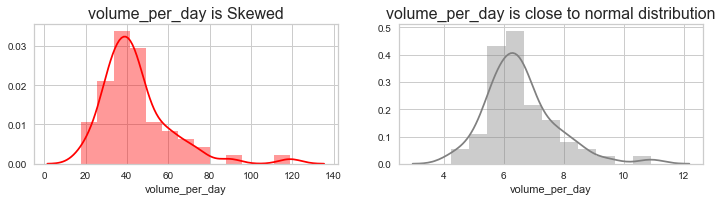

In [5]:
df =rawData
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df['volume_per_day'],color='red')
g1.set_title("volume_per_day is Skewed", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(np.sqrt(rawData['volume_per_day']),color='grey')
g2.set_title("volume_per_day is close to normal distribution", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)
plt.show()

In [6]:
#Transformation
rawData['volume_per_day']=np.sqrt(rawData['volume_per_day'])
rawData['intensity_per_day']=np.sqrt(rawData['intensity_per_day'])

In [7]:
#from sklearn.preprocessing import MinMaxScaler
#Scaling Numerical columns
#cat_col =['favorite_exercise','most_recent_exercise']
#target_col=['churn_user'] 
#Id_col     = ['first_use_date','fake_user_id','last_use_date', 'favorite_exercise','most_recent_exercise']
#num_cols   = [x for x in rawData.columns if x not in cat_col + target_col + Id_col]
#std = MinMaxScaler()
#scaled = std.fit_transform(rawData[num_cols])
#scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
#rawData = rawData.drop(columns = num_cols,axis = 1)
#rawData = rawData.merge(scaled,left_index=True,right_index=True,how = "left")


# Data Preprocessing (2): Feature Engineering

We have 9 categories in exercise type, and there are no ordinal order between those categoris.
If using one-hot, we will have too many dimensions. 

🔥 As I considers that if later I can use workout plans to train the model, it is expeceted to produce more dimensions. So here I will introduce and adopt target encoding which will keep the original dimensions and make the category connected with the target variable! 


In [8]:
#Encoding for favorite_exercise, most_recent_exercise
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
    def fit(self, X, y):
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):

        return self.fit(X, y).transform(X, y)

In [9]:
# Target encode the categorical data
pick_x_cat =[11,12]
pick_x=[3,4,5,6,7,8,9,10,13,14,15,16,17]+pick_x_cat
pick_y=[18]                                                  

x = rawData.iloc[:,pick_x]
y = rawData.iloc[:,pick_y]

replace_cols=['churn_user']
for i in replace_cols : 
    y[i]  = y[i].replace({'1.0' : 1, '0.0':0})
te = TargetEncoder()
x_target_encoded = te.fit_transform(X=x, y=y)
x_target_encoded.shape[0]

61

# Step2: Understand the Feature Importance

# Feature Importance (1) : Embeded Method

In [10]:
#Use Embeded Method to Pick the Most Important Variables
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#Embeded Method:
reg = LassoCV()
reg.fit(x_target_encoded, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x_target_encoded, y))
coef = pd.Series(reg.coef_, index = x.columns)

Best alpha using built-in LassoCV: 12.391716
Best score using built-in LassoCV: 0.091342


In [11]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 2 variables and eliminated the other 13 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

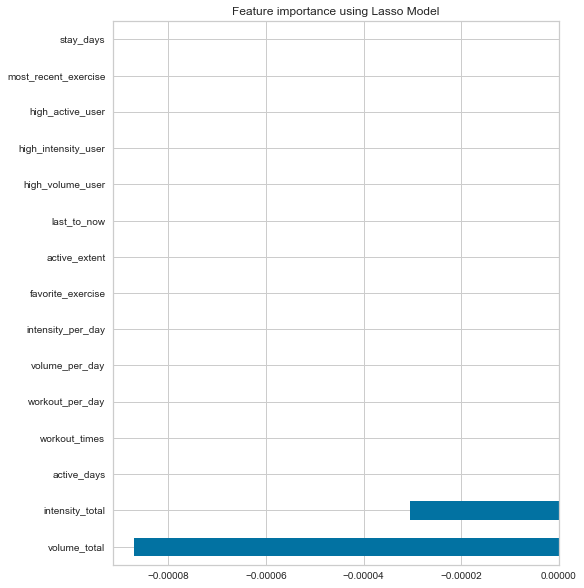

In [12]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

intensity_total and volume_total is picked as important data variables!

# Feature Importance (2) : Filter Method

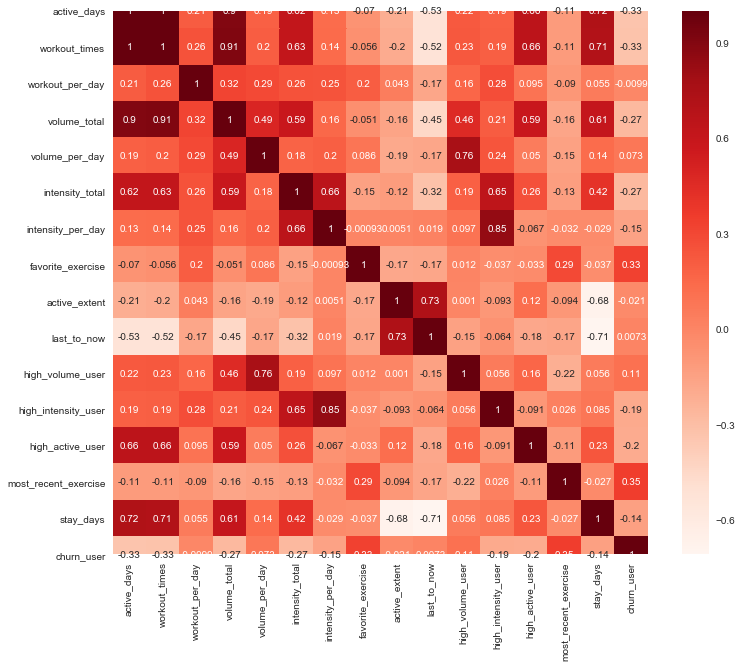

In [13]:
corrData = pd.concat( [x_target_encoded,y], axis=1 )
corrData
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = corrData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Pick variables which has more than 0.2 correlation with target variable ('churn_user')!

In [14]:
#Correlation with output variable
cor_target = abs(cor["churn_user"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

active_days             0.328668
workout_times           0.326797
volume_total            0.273981
intensity_total         0.272667
favorite_exercise       0.328989
high_active_user        0.200976
most_recent_exercise    0.349999
churn_user              1.000000
Name: churn_user, dtype: float64

# Feature Importance (3) : Wrapper Method

In [15]:
#Wrapper Method
#Feed the features to the selected Machine Learning algorithm and based on the 
#model performance you add/remove the features.
# Here I only choose Backward Elimination
#Adding constant column of ones, mandatory for sm.OLS model
import statsmodels.api as sm

#Backward Elimination
cols = list(x_target_encoded.columns)
pmax = 1
while (len(cols)>0):
    p= []
    x_new = x_target_encoded[cols]
    #x_new = sm.add_constant(x_new)
    model = sm.OLS(y,x_new.astype(float)).fit()
    p = pd.Series(model.pvalues.values[0:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['active_days', 'high_volume_user', 'most_recent_exercise']


# Step3: Build ML Model

In [29]:
# Split into training and testing data
data_prepared=x_target_encoded
data_labels=y
train_features, test_features, train_labels, test_labels = train_test_split(
    data_prepared,data_labels,test_size=0.25, random_state = 42)
a=train_labels['churn_user'].tolist()

# Model1: Random Forest

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz 
from sklearn.metrics import precision_score, recall_score, f1_score
#Create the basic model with 100 trees
base_rf = RandomForestClassifier(n_estimators=30,
                               bootstrap = True,
                               max_features = 'sqrt',
                                criterion='entropy'   )

RandomForest_scores = cross_val_score(base_rf, train_features, train_labels, scoring='roc_auc', cv=10)
RandomForest_roc = RandomForest_scores.mean()
print('The mean ROC for Random Forest is:', RandomForest_roc)

base_rf.fit(train_features, train_labels)

The mean ROC for Random Forest is: 0.7333333333333334


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=30)

# Evaluate the Random Forest on the Test Dataset

Precision: 0.250
Recall: 0.200
F1: 0.222


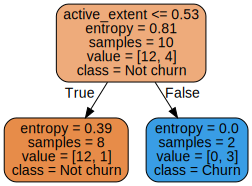

RandomForestClassifier(criterion='entropy', max_depth=1, n_estimators=30)
Accuracy   Score :  1.0
Area under curve :  1.0 



/Users/celiahah/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



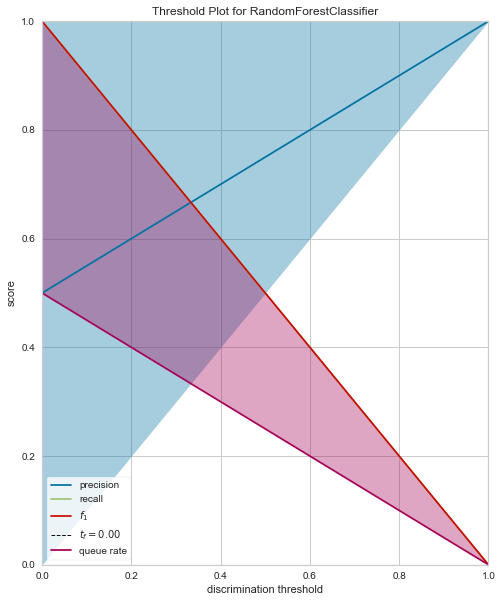

In [24]:
#Visulization for Performance Metrics
def plot_tree_randomforest(cols, nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    df_all = test_features
    df_all['churn_user']=test_labels['churn_user']
    target_col = ["churn_user"]
    dataframe = df_all.copy()
    #train and test datasets
    rf_x     = dataframe[[i for i in cols if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = graphviz.Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = cols, 
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        Fitbod_churn_prediction(rfc,
                                 rf_x,test_features[cols],
                                 rf_y,test_labels,
                                 cols,"features",threshold_plot = True)
        
#Evaluate 
# Actual class predictions
rf_predictions = base_rf.predict(test_features)
# Probabilities for each class
rf_probs = base_rf.predict_proba(test_features)[:, 1]

print('Precision: %.3f' % precision_score(y_true=test_labels, y_pred=rf_predictions))
print('Recall: %.3f' % recall_score(y_true=test_labels, y_pred=rf_predictions))
print('F1: %.3f' % f1_score(y_true=test_labels, y_pred=rf_predictions))
cols = [ i for i in test_features.columns] 
plot_tree_randomforest(cols,30,20,1,"entropy",True)

# Model2: Logistic Regression

In [20]:
data_prepared=x_target_encoded
data_labels=y
train_features, test_features, train_labels, test_labels = train_test_split(
    data_prepared,data_labels,test_size=0.25, random_state = 42)
a=train_labels['churn_user'].tolist()

In [21]:
#Establish a baseline model
base_LR = LogisticRegression()

# Default hyperparamters
hyperparameters = base_LR.get_params()
print(hyperparameters)

LR_scores = cross_val_score(base_LR, train_features, train_labels, scoring='roc_auc', cv=10)
print('The mean AUC for Logistic Regression is:', LR_scores.mean())

base_LR.fit(train_features, train_labels)

# Actual class predictions
LR_predictions = base_LR.predict(test_features)
# Probabilities for each class
base_LR_probs = base_LR.predict_proba(test_features)[:, 1]

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
The mean AUC for Logistic Regression is: 0.6416666666666667


# Evaluate Performance of LR on Test Dataset

In [22]:
print('Precision: %.3f' % precision_score(y_true=test_labels, y_pred=LR_predictions))
print('Recall: %.3f' % recall_score(y_true=test_labels, y_pred=LR_predictions))
print('F1: %.3f' % f1_score(y_true=test_labels, y_pred=LR_predictions))

Precision: 0.400
Recall: 0.400
F1: 0.400


LogisticRegression()
Accuracy   Score :  0.625
Area under curve :  0.5636363636363636 



/Users/celiahah/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



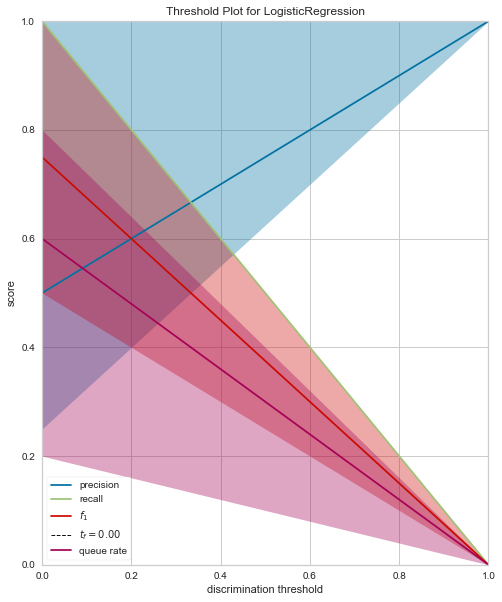

In [23]:
def Fitbod_churn_prediction(algorithm,train_features,test_features,
                             train_labels,test_labels,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(train_features,train_labels)
    predictions   = algorithm.predict(test_features)
    probabilities = algorithm.predict_proba(test_features)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    print (algorithm)
    #print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(test_labels,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(test_labels,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(test_labels,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(test_labels,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(train_features,train_labels)
        visualizer.poof()
        
#logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          #intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          #penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          #verbose=0, warm_start=False)

Fitbod_churn_prediction(base_LR,train_features,test_features,train_labels,test_labels,cols,
                         "coefficients",threshold_plot = True)

# Model3: KNN

Knn algorithm is good if I want to smote oversampled data (as the dataset is unbalanced)!

In [30]:
from sklearn.neighbors import KNeighborsClassifier as knn
#Establish a baseline model
base_knn = knn(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

# Default hyperparamters
hyperparameters = base_knn.get_params()
print(hyperparameters)

knn_scores = cross_val_score(base_knn, train_features, train_labels, scoring='roc_auc', cv=10)
print('The mean AUC for KNN is:', knn_scores.mean())

base_knn.fit(train_features, train_labels)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
The mean AUC for KNN is: 0.4041666666666667


KNeighborsClassifier(n_jobs=1)

# Evaluate Performance of KNN on Test Dataset

In [31]:
# Actual class predictions
knn_predictions = base_knn.predict(test_features)
# Probabilities for each class
base_knn_probs = base_knn.predict_proba(test_features)[:, 1]
base_knn_probs
#Performance Metrics for test
#knn_scores = cross_val_score(base_knn, test_features, test_labels, scoring='roc_auc', cv=10)
print('Precision: %.3f' % precision_score(y_true=test_labels, y_pred=knn_predictions))
print('Recall: %.3f' % recall_score(y_true=test_labels, y_pred=knn_predictions))
print('F1: %.3f' % f1_score(y_true=test_labels, y_pred=knn_predictions))

Precision: 0.500
Recall: 0.200
F1: 0.286


KNeighborsClassifier(n_jobs=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.50      0.20      0.29         5

    accuracy                           0.69        16
   macro avg       0.61      0.55      0.54        16
weighted avg       0.65      0.69      0.64        16

Accuracy Score   :  0.6875
Area under curve :  0.5545454545454545


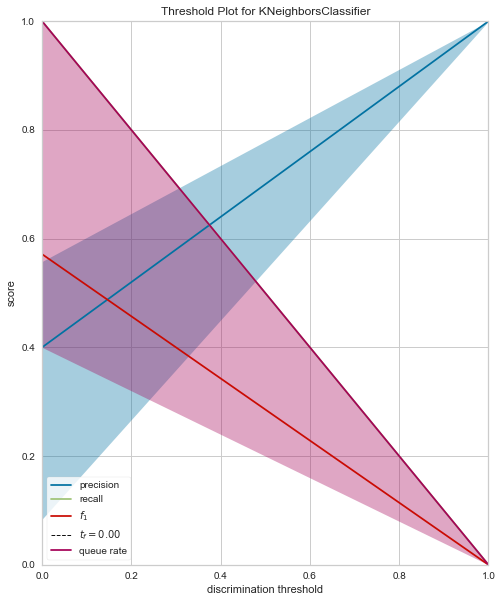

In [32]:
def Fitbod_churn_prediction_alg(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc)
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #plot roc curve
    trace1 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                       )
    trace2 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Blues",name = "matrix",
                        xaxis = "x2",yaxis = "y2"
                       )
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.6],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255, 255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                            )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

Fitbod_churn_prediction_alg(base_knn,train_features,test_features,
                             train_labels,test_labels,threshold_plot = True)

# Hyper Parameter Tuning: Use GridSearchCV

In [38]:
data_prepared=x_target_encoded
data_labels=y
train_features, test_features, train_labels, test_labels = train_test_split(
    data_prepared,data_labels,test_size=0.25, random_state = 42)
a=train_labels['churn_user'].tolist()

In [39]:
#----Hyper Parameter Tuning: Use GridSearchCV--------------
import sklearn
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
              {'bootstrap':[False],'n_estimators':[3,10,20,30,40],'max_features':[2,3,4]}]
forest_reg = RandomForestClassifier()
grid_search = GridSearchCV(forest_reg, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(train_features,train_labels)

cvres = grid_search.cv_results_ # the variable that stores the grid search results
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):  # iterate over the tested configurations
    print(mean_score, params)

grid_search.best_params_
grid_search.best_estimator_ # variable holding the best classifier (fitted on the entire dataset)

final_model = grid_search.best_estimator_

#Evaluate the best model on the test data
final_model.fit(train_features, train_labels)
preds = final_model.predict_proba(test_features)[:, 1]
RF_predictions = final_model.predict(test_features)
baseline_auc66 = roc_auc_score(test_labels, preds)
print('The final tuned Random Forest model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc66))

0.5875 {'max_features': 2, 'n_estimators': 3}
0.5708333333333333 {'max_features': 2, 'n_estimators': 10}
0.5625000000000001 {'max_features': 2, 'n_estimators': 30}
0.55 {'max_features': 4, 'n_estimators': 3}
0.5583333333333333 {'max_features': 4, 'n_estimators': 10}
0.6166666666666667 {'max_features': 4, 'n_estimators': 30}
0.7166666666666667 {'max_features': 6, 'n_estimators': 3}
0.6 {'max_features': 6, 'n_estimators': 10}
0.6375000000000001 {'max_features': 6, 'n_estimators': 30}
0.7125 {'max_features': 8, 'n_estimators': 3}
0.675 {'max_features': 8, 'n_estimators': 10}
0.7833333333333334 {'max_features': 8, 'n_estimators': 30}
0.6125 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.6916666666666667 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.6583333333333334 {'bootstrap': False, 'max_features': 2, 'n_estimators': 20}
0.675 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
0.6666666666666667 {'bootstrap': False, 'max_features': 2, 'n_estimators

Precision: 0.500
Recall: 0.400
F1: 0.444


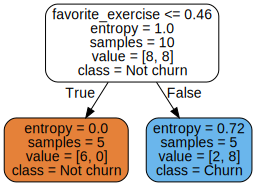

RandomForestClassifier(criterion='entropy', max_depth=1, n_estimators=30)
Accuracy   Score :  0.9375
Area under curve :  0.9 



/Users/celiahah/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



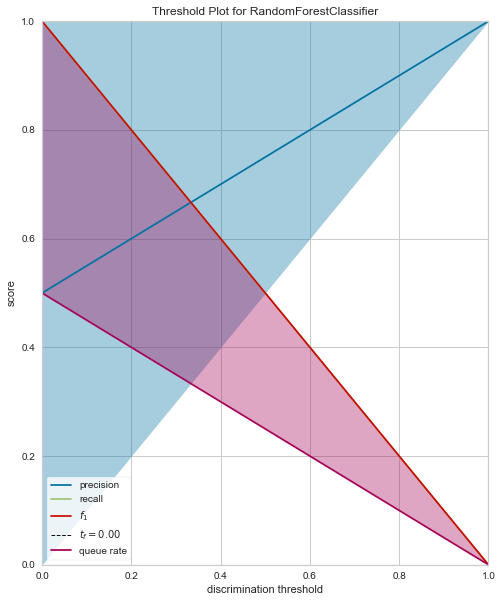

In [41]:
print('Precision: %.3f' % precision_score(y_true=test_labels, y_pred=RF_predictions))
print('Recall: %.3f' % recall_score(y_true=test_labels, y_pred=RF_predictions))
print('F1: %.3f' % f1_score(y_true=test_labels, y_pred=RF_predictions))
cols = [ i for i in test_features.columns] 
plot_tree_randomforest(cols,30,20,1,"entropy",True)

In [ ]:
ra